# Using raw data to generate polarization images database with rayleigh model for comparison, and figures

This code is the most important one for end user of this database. It generate and example of figures and polarimetric treatment of images of the database and generate another database with csv file.

Input : PolarizedDatabase folder with images grouped in numpy files

Output : PolarizedDatabaseProcessed with csv values and folders sorted by date, with folders for each image with a figure and AOP, DOP calculated with Rayleigh model for comparison.

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
import skimage.io
import skimage.filters
import cv2
import time
from scipy.spatial.transform import Rotation as R


from tqdm import tqdm
from p_tqdm import p_map

import centroide_images
import ephemeride
import rayleigh

import csv

import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm

In [ ]:
in_path="/scratch/lpoughon/PolarizedDatabase/"
calib_path="/scratch/lpoughon/PolarizedDatabase/calib/"
out_path="/scratch/lpoughon/PolarizedDatabaseProcessed/"
limit_Zenith_Angle=np.pi*0.5 #Limit Zenith Angle to crop circularly data inside of camera field-of-view.


In [ ]:
def cart2sph2(x,y,z):
    """
    Entree : trois tableaux numpy avec les n coordonnées selon l'axe x, y et z de n vecteurs
    Sortie : deux tableaux numpy avec les n coordonnées en azimut et elevation, en radians, avec la convention elevation  à pi/2 si vecteur selon le plan x-y, et nulle selon z.
    """
    azimuth = np.arctan2(y,x)
    elevation = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, elevation


def sph2cart2(azimuth,elevation):
    """
    Entree : deux tableaux numpy avec les n coordonnées en azimut et elevation, en radians, avec la convention elevation  à pi/2 si vecteur selon le plan x-y, et nulle selon z.
    Sortie : trois tableaux numpy avec les n coordonnées selon l'axe x, y et z de n vecteurs
    """
    x = np.cos(np.pi/2-elevation) * np.cos(azimuth)
    y = np.cos(np.pi/2-elevation) * np.sin(azimuth)
    z = np.sin(np.pi/2-elevation)
    return x, y, z

def average_angle(angle1,angle2):
    x=np.cos(angle1)+np.cos(angle2)
    y=np.sin(angle1)+np.sin(angle2)
    return np.arctan2(y,x)

def rebin(arr, new_shape): #https://scipython.com/blog/binning-a-2d-array-in-numpy/
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f,XCoeff,YCoeff):
    theta2=(np.hypot(((centroides[:,1]-y_0)*XCoeff),((centroides[:,0]-x_0)*YCoeff))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0)*YCoeff,(centroides[:,1]-y_0)*XCoeff)
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

degrees=np.pi/180

In [ ]:
#Camera color-polarization pattern
#definition of which color of the pixel is used for simple figure example
couleur=3 #is blue
# 0 : R     1 : G
# 2 : G     3 : B
#definition of which polarizer orientation is used
# indice_pol=0 is 0°
# 0 :  0°   1 : 45°
# 2 : 135°  3 : 90°
#0° -> Vertical

#Load parameters from calibrations files
[crop_x_min,crop_x_max,crop_y_min,crop_y_max]=np.load(calib_path+"params_crop.npy")
(XSensor,YSensor)=(crop_x_min-crop_x_max,crop_y_max-crop_y_min) # Cropped sensor size en pixels*pixels

dist_center=np.load(calib_path+'dist_center.npy') #[1.215145972506110e+03,1.030433565024923e+03]
x_0,y_0=dist_center[0]-crop_x_min,dist_center[1]-crop_y_min #Cropped images optical center of distorsion.


eph=ephemeride.ephemerides() #Initialisation of ephemerids class to get ephemerids figure.

In [ ]:
dirs = os.listdir( in_path ) # Listing Files
dirs_files=[]
for file in dirs:
    if file[-7:]=='raw.npy': # Keeping only ones with ".npy" files. 
        dirs_files.append(file)
dirs_files.sort() #We sort the files in alphabetical order. 
# Since the format is YYYY-MM-DDTHH-mm-ss.npy, the files are sorted in chronological order.


In [ ]:
print(dirs_files)

### Load one image to have an example

In [ ]:
print("File used :",in_path+dirs_files[1])
images_pola=np.load(in_path+dirs_files[1],allow_pickle=True)
images_pola.shape

sat_level=65500
image_max=65520


image_pola=images_pola[503]
print(image_pola)
image=image_pola[0]
# Créer une color map personnalisée
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0), (1, 1, 1)], N=sat_level)
# Créer une figure et un axe
fig, ax = plt.subplots()

# Créer une image avec des valeurs aléatoires entre 0 et 65519
#image = np.random.randint(0, 65520, size=(100, 100), dtype=np.uint16)

# Afficher l'image avec la color map personnalisée
im = ax.imshow(image, cmap=cmap,norm=LogNorm())



# Set the color of the maximum value to red
im.set_clim(vmin=160, vmax=sat_level)
im.cmap.set_over('red')

# Ajouter une colorbar
cbar = plt.colorbar(im, ax=ax)
# Afficher la figure
plt.show()

In [ ]:

plt.imshow(image_pola[0])
plt.colorbar()

In [ ]:
theta=np.load(calib_path+"theta_crop.npy")
alpha=np.load(calib_path+"alpha_crop.npy")
f=float(np.load(calib_path+"f.npy"))
rot_mat=np.load(calib_path+"rot_mat.npy")
print(theta.shape)
print(alpha.shape)

### Generate a figure like the one in IEEE conference article :
#### https://ieeexplore.ieee.org/document/10325176
#### https://hal.science/hal-04267766

In [10]:
theta_0=theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
theta_90=theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
theta_45=theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
theta_135=theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))


def generate_IEEE_conference_article_figure(image_pola):    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps) 
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])
        
    #Calculation of stokes parameters and of AOP and DOP    
    Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
    U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
    I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
    ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
    ksi[theta_mini>np.pi*0.45]=0
            
    print("Creation figure ...")
    fig,(ax1,ax2)=plt.subplots(2,3,figsize=(20,12),gridspec_kw={'width_ratios':[0.95,1.2,1.2]})

    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
            
            
    print("plot aop image...")
    pcm1=ax2[1].pcolormesh(ksi,cmap='hsv')
    ax2[1].set_title("Measured AOP")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbar=fig.colorbar(pcm1,ax=ax2[1],shrink=0.9)
    cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
    cbar.set_label("Angle of Polarization (°)")
    ax2[1].invert_yaxis()

    print("plot dop image...")
    DOP_dofp=np.hypot(Q,U)/I 
    DOP_dofp[theta_mini>np.pi*.45]=0
    pcm3=ax2[2].pcolormesh(np.minimum(DOP_dofp,1),cmap='jet',vmin=0.0, vmax=1.0)
    ax2[2].set_title("Measured DOP")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbardop=fig.colorbar(pcm3,ax=ax2[2],shrink=0.9)
    pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
    cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbardop.set_label("Degree of Polarization")
    ax2[2].invert_yaxis()

    print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    #imageRGB=cv2.merge((a[1::2,1::2],a[0::2,1::2],a[0::2,0::2]))
    imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax2[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax2[0],shrink=0.9)
    ax2[0].set_aspect('equal')
      
    d=np.pi/180
    r = R.from_matrix(rot_mat)
            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    #x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax2[0].set_title("RGB Image")                 
    print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax1[0])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
            
    print("plot simul rayleigh...")
    
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax1[1],ax_dop=ax1[2],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)

    ax2[1].invert_yaxis()
    ax2[2].invert_yaxis()            

          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
    ax2[0].axis('scaled')
    ax2[1].axis('scaled')
    ax2[2].axis('scaled')
    ax1[1].axis('scaled')
    ax1[2].axis('scaled')
    cbarrgb.remove()
    return (U,Q,I,ksi,DOP_dofp,fig)

Creation figure ...
plot aop image...
plot dop image...
plot rgb image...
Psi_sun : 4.879579627892318 Theta_sun : 1.275571784317284
Sun_rot[0] : 2.5207039906501687 Sun_rot[1] : 1.299056788465535
plot ephemeride...
plot simul rayleigh...


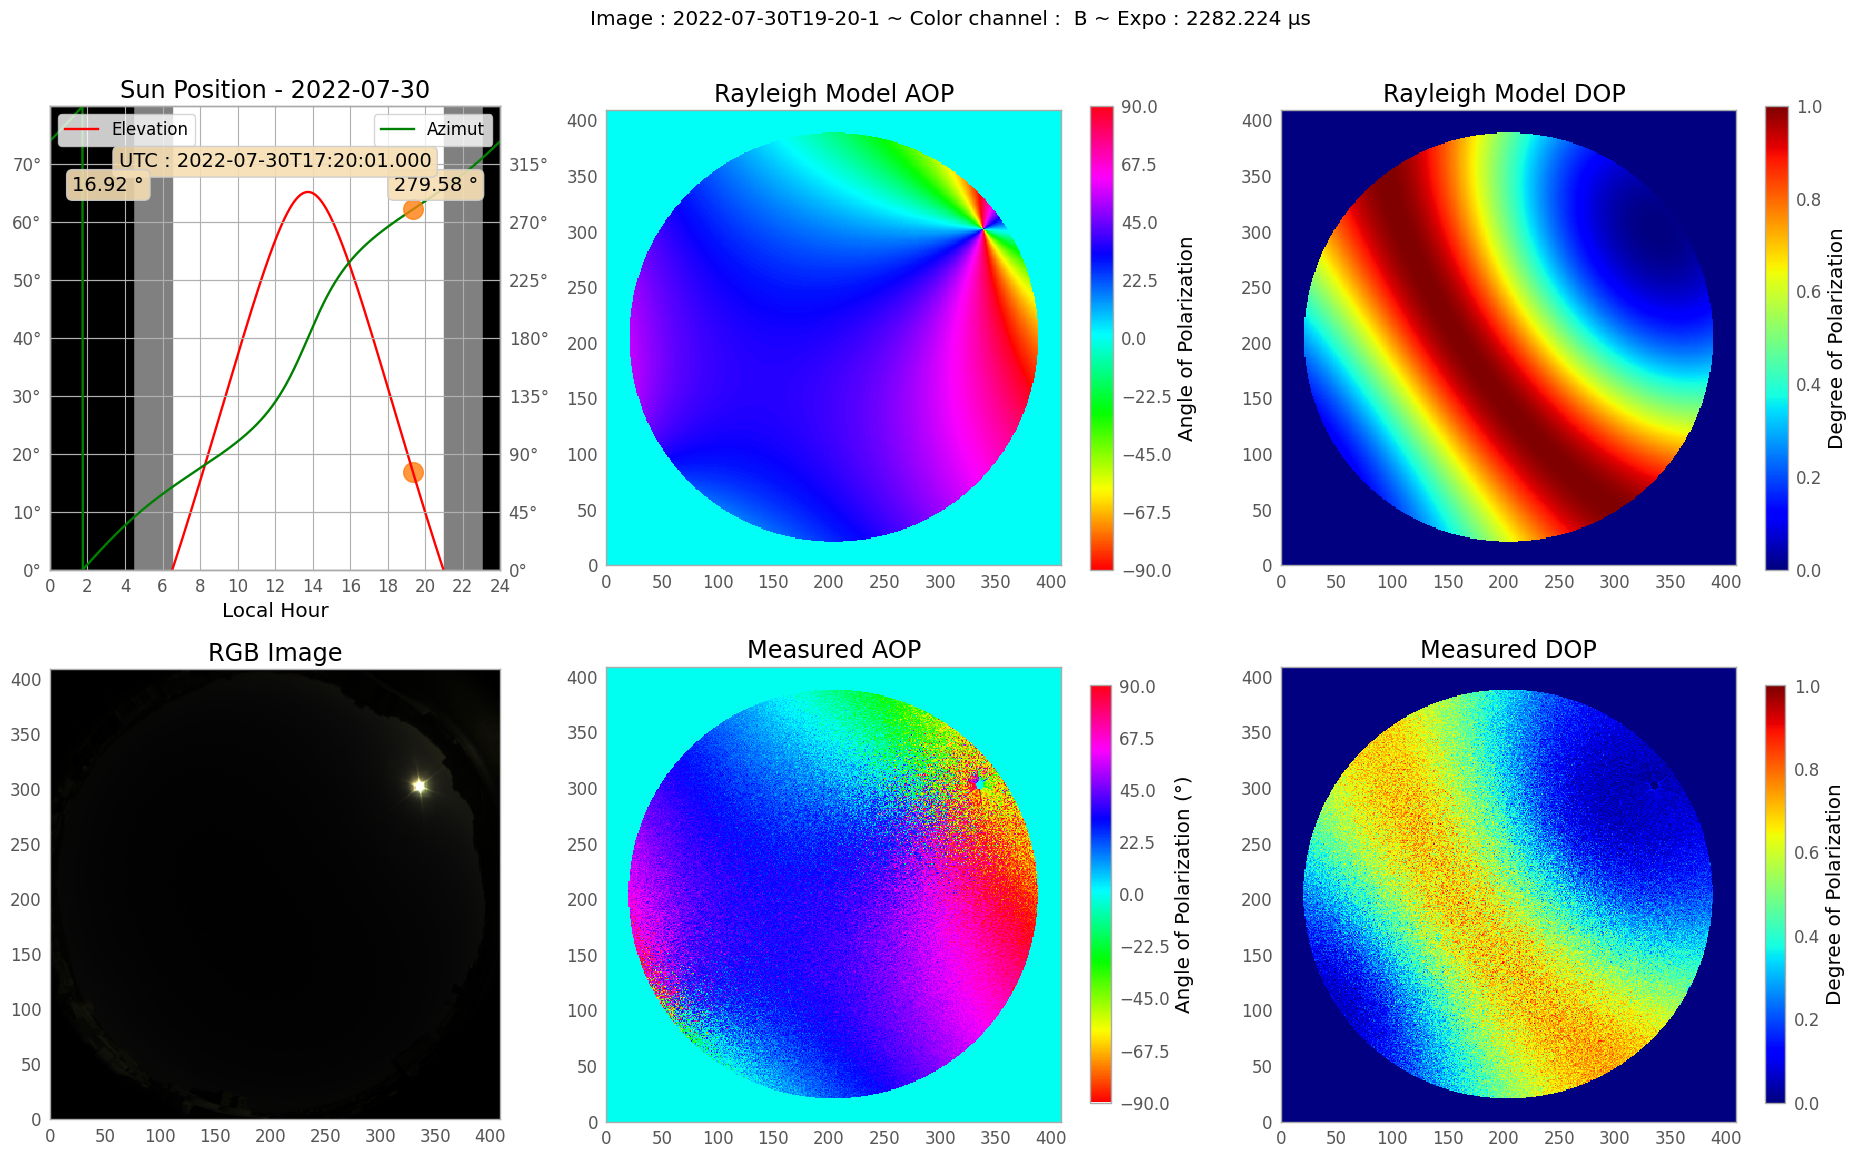

In [11]:
U,Q,I,A,D,mafig=generate_IEEE_conference_article_figure(image_pola)

In [12]:
mafig.savefig("test_figure.png")

In [13]:
mafig.show()

In [14]:
np.seterr(divide='ignore', invalid='ignore')  # Ignore division by zero and invalid value warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Calculation of AOP/DOP figure and values for each color, with Rayleigh simulation

In [15]:
def AOP_DOP_process_save_and_figure(image_pola,save=True,sat_level=65500):
    verbose_text=False
    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    type_image=image_pola[3]
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps)
    
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')
    
    chemin_enreg=out_path+chainedate+'/'
    if save:
        if not os.path.exists(chemin_enreg):
            try:
                os.mkdir(chemin_enreg)
            except Exception as e:print(e)
        #if os.path.exists(chemin_enreg+chainetps):return [None]
        if not os.path.exists(chemin_enreg+chainetps):
            try:
                os.mkdir(chemin_enreg+chainetps)
            except Exception as e:print(e)
        np.save(chemin_enreg+chainetps+"/image.npy",image)

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])

    # Here we want to calculate the "average angle" seen at the center of a macropixel. 
    # We know the orientations of each sub-pixel (theta, alpha). However, a simple average 
    # does not work for finding the "central" orientation. For instance, the "average" between 
    # two 2D vectors with angles 45° and 315° would "actually" be 0°, but the arithmetic mean of
    # the two angles is 180°. Here, we encounter the same problem when transitioning from -π to π 
    # with numerical artifacts. To avoid this, we convert back to Cartesian coordinates and use atan2.    
            
    if verbose_text:print("Creation figure ...")
    fig,(ax0,ax2,ax3)=plt.subplots(3,4,figsize=(24,20),gridspec_kw={'width_ratios':[1.2,1.2,1.2,1.2]})
    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Expo : "+str(expo)+" µs")
    
    
    if verbose_text:print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax0[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax0[1],shrink=0.9)
    ax0[0].set_aspect('equal')
    #ax2[0].imshow(cv2.cvtColor((imageRGB.astype('float32')/255.0).astype('uint8'), cv2.COLOR_BGR2RGB))
    #ax2[0].grid(False)        
    d=np.pi/180
    r = R.from_matrix(rot_mat)

            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    if verbose_text:print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    if verbose_text:print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax0[0].set_title("RGB Image")                 

            
    if verbose_text:print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax0[1])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
                    

    for couleur in range(4):
        # Processing AOP and DOP for each color and saving it, and plot it

        #put a Nan Value on zones where at least one pixels of macropixel was saturated
        sat_zone=((image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]>sat_level) | 
                  (image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]>sat_level) |
                  (image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]>sat_level) |
                  (image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]>sat_level))

        
        #AOP values calculation
        Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
        ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
        ksi[theta_mini>limit_Zenith_Angle]=np.nan    
        ksi[sat_zone]=np.nan
        #getting right subfigure to plot it
        if couleur==0 or couleur==1 :
            ax_coul_aop=[ax2,ax3][couleur][0]
            ax_coul_dop=[ax2,ax3][couleur][1]
            if verbose_text:print(couleur)
        if couleur==2 or couleur==3 :
            ax_coul_aop=[ax2,ax3][couleur-2][2]
            ax_coul_dop=[ax2,ax3][couleur-2][3]
            if verbose_text:print(couleur)
        #ax_coul
        
        #save AOP value
        if save:np.save(chemin_enreg+chainetps+"/AOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",ksi)
            
        
        #Plot it
        if verbose_text:print("plot aop image...")
        cmap_hsv = plt.cm.hsv  # You can use any colormap you prefer
        cmap_hsv.set_bad('black', alpha=1.0)
        pcm1=ax_coul_aop.pcolormesh(ksi,cmap=cmap_hsv,vmin=-90.0, vmax=90.0)
        ax_coul_aop.set_title("Measured AOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbar=fig.colorbar(pcm1,ax=ax_coul_aop,shrink=0.9)
        cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
        cbar.set_label("Angle of Polarization (°)")
        #ax_coul_aop.invert_yaxis()

        if verbose_text:print("plot dop image...")
        # DOP values calculation
        DOP_dofp=np.hypot(Q,U)/I 
        DOP_dofp[theta_mini>limit_Zenith_Angle]=np.nan
        DOP_dofp[sat_zone]=np.nan
        
        #save it
        if save:np.save(chemin_enreg+chainetps+"/DOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",DOP_dofp)
        
        #plot it
        # Create a custom colormap with black for NaN values
        cmap_jet = plt.cm.jet  # You can use any colormap you prefer
        cmap_jet.set_bad('black', alpha=1.0)
        pcm3=ax_coul_dop.pcolormesh(np.minimum(DOP_dofp,1),cmap=cmap_jet,vmin=0.0, vmax=1.0)
        ax_coul_dop.set_title("Measured DOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbardop=fig.colorbar(pcm3,ax=ax_coul_dop,shrink=0.9)
        pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
        cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
        cbardop.set_label("Degree of Polarization")
          
        ax_coul_aop.axis('scaled')
        ax_coul_dop.axis('scaled')

            
    if verbose_text:print("plot simul rayleigh...")
    #Show rayleigh simulation and save its values
    #AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,
Theta=theta,rot_mat=rot_mat,limit_Zenith_Angle=limit_Zenith_Angle,out_zone=np.nan)#orientation_pixels_ENU=orientation_ENU)


          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)

    ax0[2].axis('scaled')
    ax0[3].axis('scaled')
    cbarrgb.remove()

    #save all data values in a folder        
    if save:np.save(chemin_enreg+chainetps+"/AOP_s.npy",AOP_s)
    if save:np.save(chemin_enreg+chainetps+"/DOP_s.npy",DOP_s)
    if save:np.save(chemin_enreg+chainetps+"/expo.npy",expo)
            
    if save:np.savetxt(chemin_enreg+chainetps+"/time.npy",list(map(int,chainetps[:-1].split('T')[0].split('-')+chainetps[:-1].split('T')[1].split('-'))),delimiter=',',fmt="%d") # ['YYYY', 'MM', 'DD', 'HH', 'mm', 'ss/']
    if verbose_text:print("Sauv fig...")
    if save:plt.savefig(chemin_enreg+chainetps+"/fig.png")
    if not save:plt.show()
    plt.close()
  
    return [chainedate+'/'+chainetps,chainetps,chaineheure[0],chaineheure[1],chaineheure[2],chainedate,Psi_sun,Theta_sun,Ha_sun,
                        Dec_sun,expo,type_image]


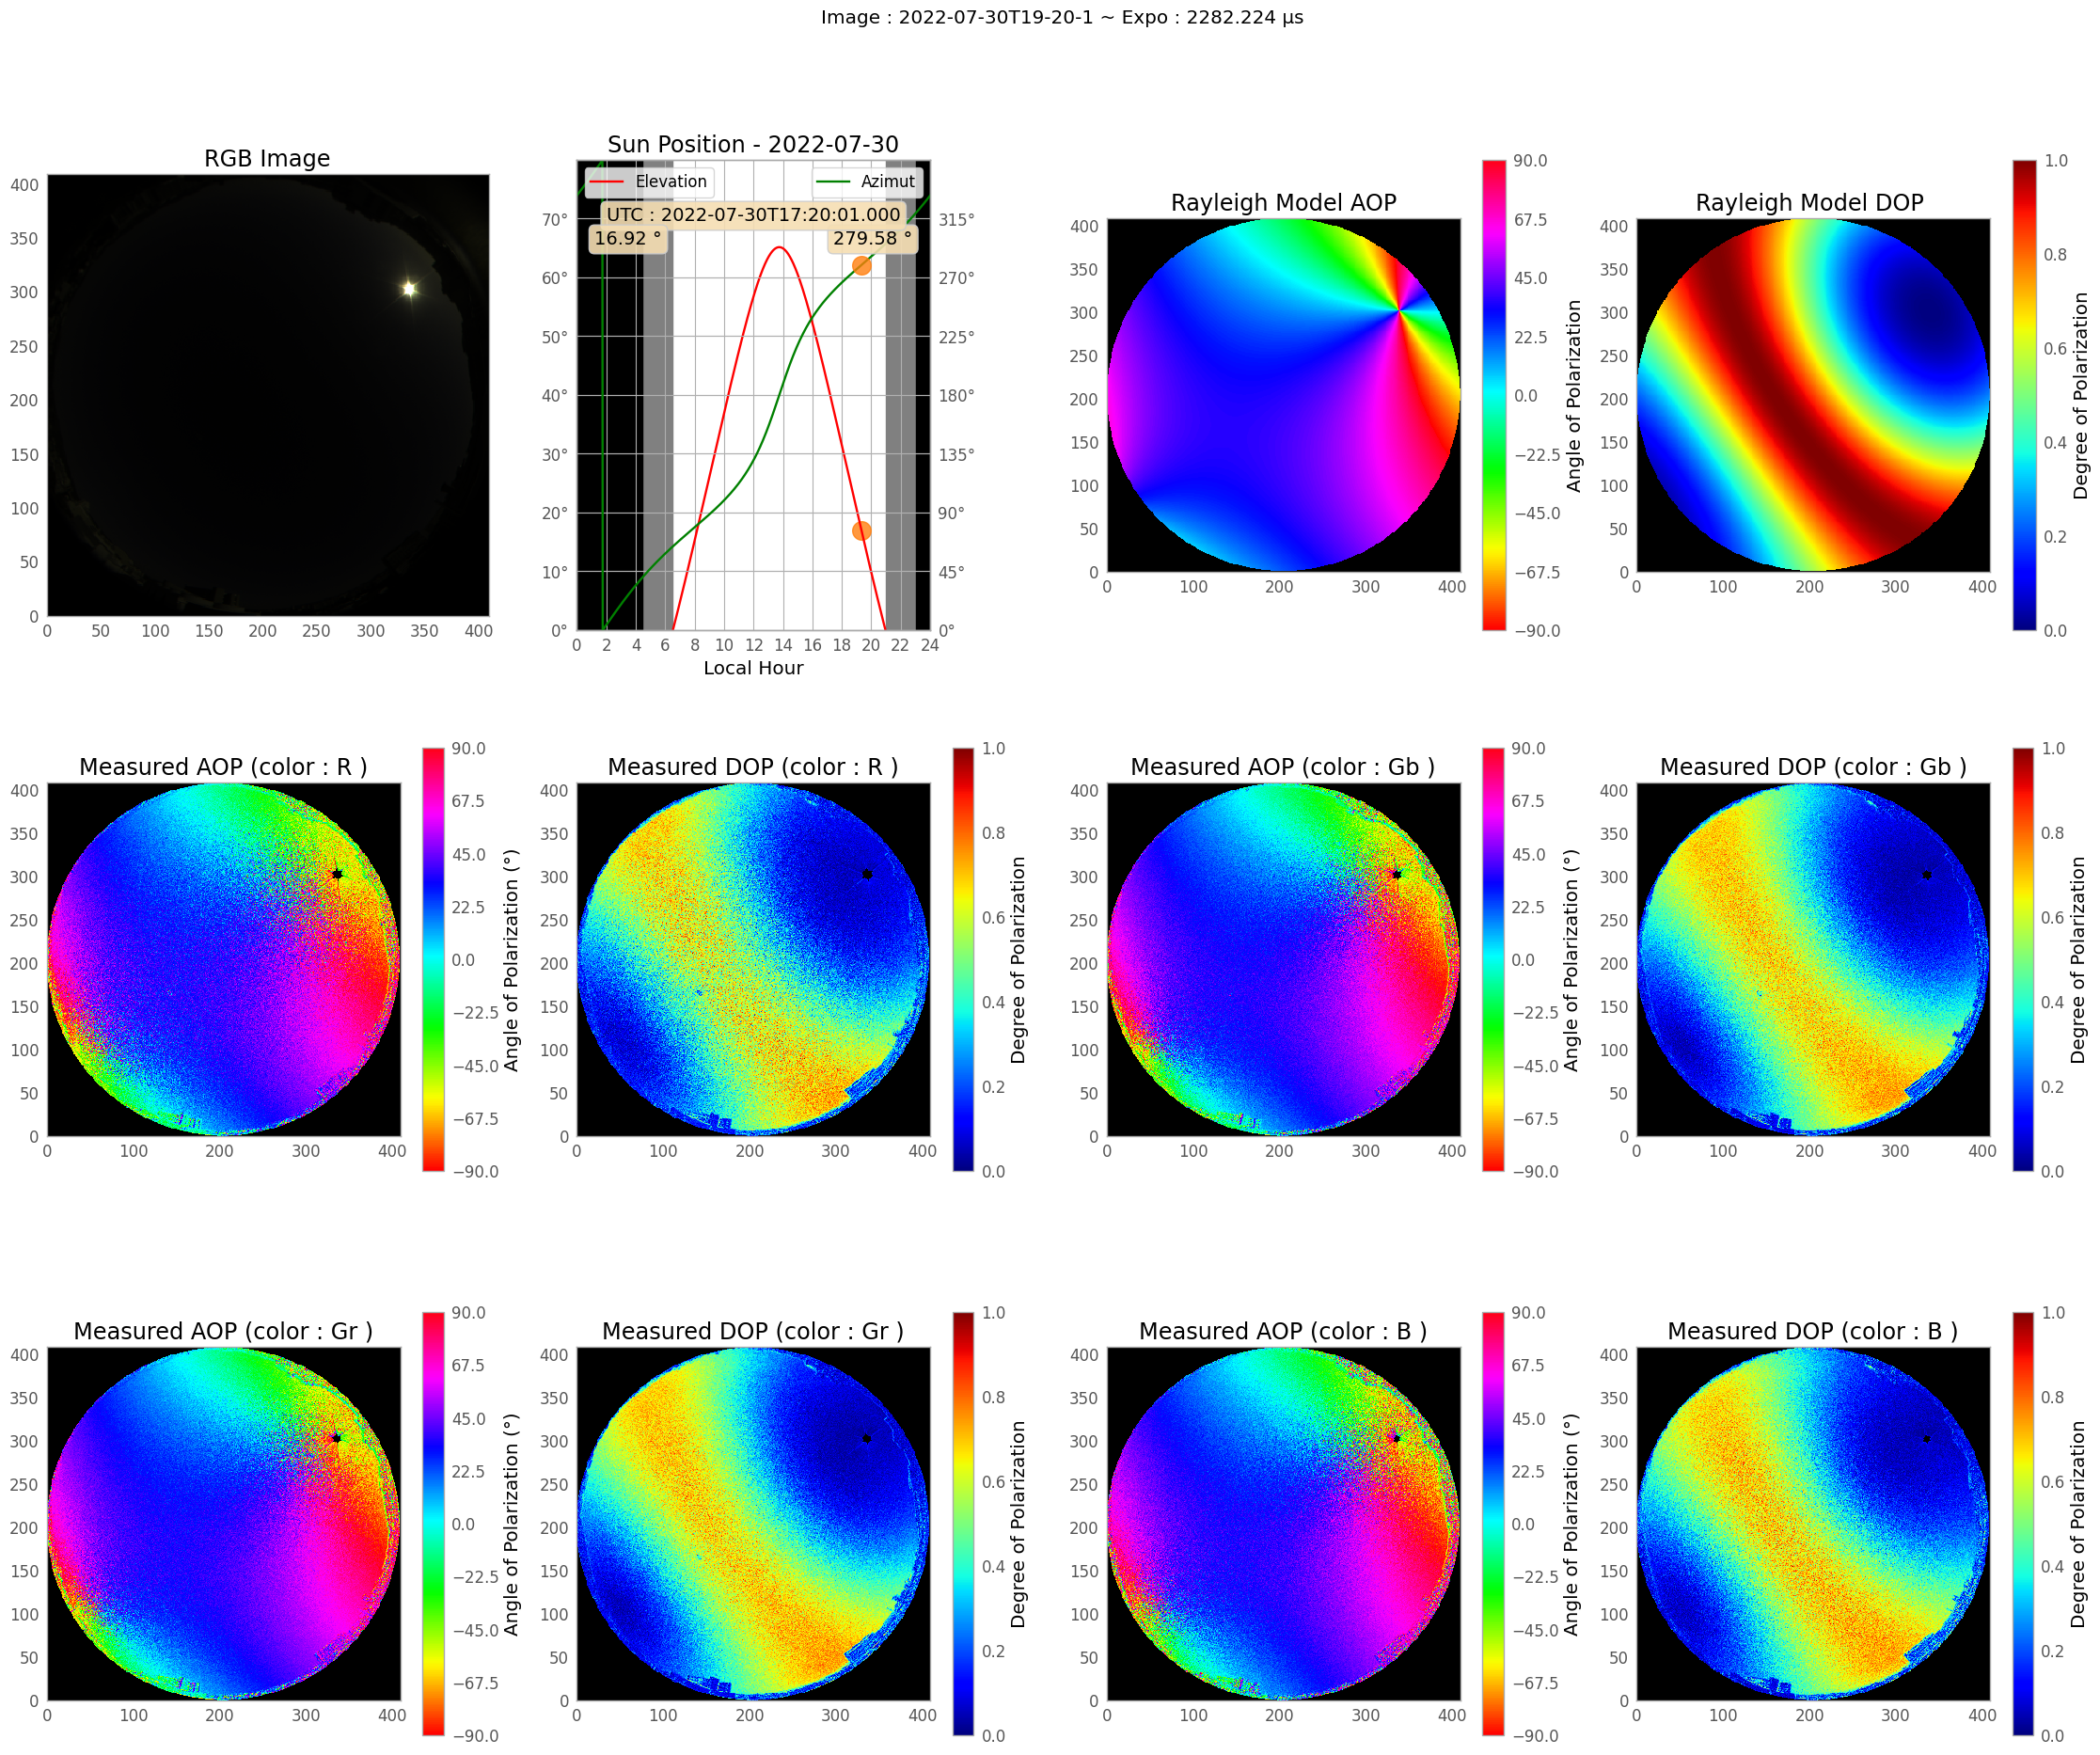

In [16]:
elt_liste=AOP_DOP_process_save_and_figure(image_pola,save=False) #show an example

### Processing for each day of database and saving into new "processed" database

In [20]:
for i in range(len(dirs_files)):
    print(i, end=" ")
    print(dirs_files[i])
    images_pola=np.load(in_path+dirs_files[i],allow_pickle=True)
    tic=time.time()
#    liste_jour=sorted_filenames_dict[key]
    #partial_process_directory_1 = partial(process_directory_1, RGB_HSV_conv=True,image_size=50)
    num_processes=32*2
    results = (p_map(AOP_DOP_process_save_and_figure ,images_pola,num_cpus=num_processes,tqdm=tqdm))
#results = np.array([sublist for sublists in results for sublist in sublists if sublist is not None])
#np.save(out_path+key+"_raw.npy",results)
    print("Elapsed Time : ",time.time()-tic)
    np.array(results).shape
    
    #Store datas in csv table
    
    # Sample data for each column


    # Specify the file name
    file_name = out_path+dirs_files[i].split("_")[0]+'.csv'

    # Write data to the CSV file
    with open(file_name, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write header row
        writer.writerow(['Image_folder_path', 'Timestamp', 'Hour_Local','Minute_Local','Second_Local', 
                         'Date', 'Sun_azimuth', 'Sun_zenith_angle', 'Sun_hour_angle', 'Sun_declination', 
                         'Camera_exposure_time','Image_type'])

        # Write data rows
        for row in results:
            writer.writerow(row)

    print(f"Data saved to {file_name}")
    print(" ")
    print(" ")
    print(" ")    

0 2022-07-29_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [01:20<00:00,  5.14it/s]


Elapsed Time :  82.94166493415833
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-29.csv
 
 
 
1 2022-07-30_raw.npy


100%|████████████████████████████████████████████████| 578/578 [01:56<00:00,  4.95it/s]


Elapsed Time :  128.33114457130432
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-30.csv
 
 
 
2 2022-07-31_raw.npy


100%|████████████████████████████████████████████████| 597/597 [02:01<00:00,  4.92it/s]


Elapsed Time :  135.12638068199158
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-31.csv
 
 
 
3 2022-08-01_raw.npy


100%|████████████████████████████████████████████████| 516/516 [01:44<00:00,  4.92it/s]


Elapsed Time :  117.12688136100769
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-01.csv
 
 
 
4 2022-08-02_raw.npy


100%|████████████████████████████████████████████████| 581/581 [01:57<00:00,  4.96it/s]


Elapsed Time :  131.20568299293518
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-02.csv
 
 
 
5 2022-08-03_raw.npy


100%|████████████████████████████████████████████████| 551/551 [01:51<00:00,  4.95it/s]


Elapsed Time :  125.27677202224731
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-03.csv
 
 
 
6 2022-08-04_raw.npy


  0%|                                                          | 0/570 [00:00<?, ?it/s]

[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-04/'


100%|████████████████████████████████████████████████| 570/570 [01:54<00:00,  4.97it/s]


Elapsed Time :  127.94691300392151
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-04.csv
 
 
 
7 2022-08-05_raw.npy


100%|████████████████████████████████████████████████| 541/541 [01:49<00:00,  4.94it/s]


Elapsed Time :  123.73800563812256
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-05.csv
 
 
 
8 2022-08-06_raw.npy


100%|████████████████████████████████████████████████| 587/587 [01:57<00:00,  4.99it/s]


Elapsed Time :  131.58411121368408
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-06.csv
 
 
 
9 2022-08-07_raw.npy


100%|████████████████████████████████████████████████| 572/572 [01:55<00:00,  4.96it/s]


Elapsed Time :  129.88595247268677
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-07.csv
 
 
 
10 2022-08-08_raw.npy


100%|████████████████████████████████████████████████| 560/560 [01:52<00:00,  4.98it/s]


Elapsed Time :  126.35169696807861
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-08.csv
 
 
 
11 2022-08-09_raw.npy


100%|████████████████████████████████████████████████| 541/541 [01:49<00:00,  4.94it/s]


Elapsed Time :  122.27687644958496
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-09.csv
 
 
 
12 2022-08-10_raw.npy


100%|████████████████████████████████████████████████| 569/569 [01:53<00:00,  5.02it/s]


Elapsed Time :  126.87553119659424
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-10.csv
 
 
 
13 2022-08-11_raw.npy


100%|████████████████████████████████████████████████| 537/537 [01:48<00:00,  4.95it/s]


Elapsed Time :  121.11350536346436
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-11.csv
 
 
 
14 2022-08-12_raw.npy


100%|████████████████████████████████████████████████| 555/555 [01:51<00:00,  4.96it/s]


Elapsed Time :  125.26439118385315
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-12.csv
 
 
 
15 2022-08-13_raw.npy


100%|████████████████████████████████████████████████| 554/554 [01:52<00:00,  4.93it/s]


Elapsed Time :  125.83157181739807
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-13.csv
 
 
 
16 2022-08-14_raw.npy


100%|████████████████████████████████████████████████| 569/569 [01:54<00:00,  4.98it/s]


Elapsed Time :  127.16775178909302
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-14.csv
 
 
 
17 2022-08-15_raw.npy


100%|████████████████████████████████████████████████| 588/588 [01:58<00:00,  4.98it/s]


Elapsed Time :  132.63573241233826
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-15.csv
 
 
 
18 2022-08-16_raw.npy


100%|████████████████████████████████████████████████| 548/548 [01:50<00:00,  4.95it/s]


Elapsed Time :  123.58281254768372
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-16.csv
 
 
 
19 2022-08-17_raw.npy


100%|████████████████████████████████████████████████| 682/682 [02:17<00:00,  4.97it/s]


Elapsed Time :  150.22892022132874
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-17.csv
 
 
 
20 2022-08-18_raw.npy


100%|████████████████████████████████████████████████| 615/615 [02:04<00:00,  4.95it/s]


Elapsed Time :  138.32000637054443
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18.csv
 
 
 
21 2022-08-19_raw.npy


100%|████████████████████████████████████████████████| 570/570 [01:54<00:00,  4.98it/s]


Elapsed Time :  128.16327834129333
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-19.csv
 
 
 
22 2022-08-20_raw.npy


100%|████████████████████████████████████████████████| 650/650 [02:09<00:00,  5.00it/s]


Elapsed Time :  142.9244041442871
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-20.csv
 
 
 
23 2022-08-21_raw.npy


100%|████████████████████████████████████████████████| 585/585 [01:56<00:00,  5.03it/s]


Elapsed Time :  127.9161171913147
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-21.csv
 
 
 
24 2022-08-22_raw.npy


100%|████████████████████████████████████████████████| 600/600 [01:59<00:00,  5.02it/s]


Elapsed Time :  131.4470772743225
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-22.csv
 
 
 
25 2022-08-23_raw.npy


100%|████████████████████████████████████████████████| 628/628 [02:06<00:00,  4.97it/s]


Elapsed Time :  138.30957698822021
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-23.csv
 
 
 
26 2022-08-24_raw.npy


100%|████████████████████████████████████████████████| 617/617 [02:02<00:00,  5.05it/s]


Elapsed Time :  134.0181701183319
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-24.csv
 
 
 
27 2022-08-25_raw.npy


100%|████████████████████████████████████████████████| 598/598 [01:59<00:00,  4.99it/s]


Elapsed Time :  131.3567237854004
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-25.csv
 
 
 
28 2022-08-26_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 575/575 [01:58<00:00,  4.85it/s]


Elapsed Time :  131.21883249282837
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-26.csv
 
 
 
29 2022-08-27_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 592/592 [01:57<00:00,  5.03it/s]


Elapsed Time :  129.8293936252594
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-27.csv
 
 
 
30 2022-08-28_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 592/592 [01:59<00:00,  4.95it/s]


Elapsed Time :  132.57289505004883
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-28.csv
 
 
 
31 2022-08-29_raw.npy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.15it/s]


Elapsed Time :  20.38916325569153
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-29.csv
 
 
 


### Merge all .csv daily files in one

In [22]:

# Input folder containing CSV files
#input_folder = 'Polarized_Database/'
# Specify the output merged CSV file
merged_csv_file = out_path+'all_days.csv'

# Initialize a list to store merged data and header
merged_data = []
merged_header = None  # Initialize the header

# Iterate through all files in the input folder
for filename in os.listdir(out_path):
    
    if filename.endswith('.csv'):
        if filename.endswith('all_days.csv'):continue
        print(filename)
        csv_file_path = os.path.join(out_path, filename)
        with open(csv_file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)  # Get the header (first row)
            
            # If merged_header is None, use the first file's header
            if merged_header is None:
                merged_header = header
            else:
                # Check if the header matches the merged_header
                if header != merged_header:
                    raise ValueError(f"CSV file {filename} has a different header structure.")
            
            # Read data rows and append to merged_data
            for row in reader:
                merged_data.append(row)
                print(row)



# Write the merged data to the output CSV file
with open(merged_csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(merged_header)  # Write merged header row
    writer.writerows(merged_data)    # Write merged data rows


2022-08-09.csv
['2022-08-09/2022-08-09T07-00-16', '2022-08-09T07-00-16', '07', '00', '16', '2022-08-09', '71.02978804998577', '86.91596267877554', '-100.9910592124283', '74.14651749844', '4550.712', '0']
['2022-08-09/2022-08-09T07-00-19', '2022-08-09T07-00-19', '07', '00', '19', '2022-08-09', '71.02978804998577', '86.91596267877554', '-100.9910592124283', '74.14651749844', '4550.712', '1']
['2022-08-09/2022-08-09T07-00-22', '2022-08-09T07-00-22', '07', '00', '22', '2022-08-09', '71.03259441895051', '86.9130963944813', '-100.98689216327259', '74.14652080173572', '447.704', '2']
['2022-08-09/2022-08-09T07-00-24', '2022-08-09T07-00-24', '07', '00', '24', '2022-08-09', '71.03259441895051', '86.9130963944813', '-100.98689216327259', '74.14652080173572', '2282.224', '3']
['2022-08-09/2022-08-09T07-00-29', '2022-08-09T07-00-29', '07', '00', '29', '2022-08-09', '71.03259441895051', '86.9130963944813', '-100.98689216327259', '74.14652080173572', '33.456', '5']
['2022-08-09/2022-08-09T07-00-32',

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
#utc explication

# Fin

In [ ]:
1/0

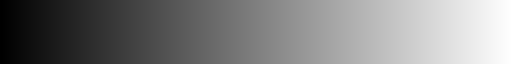

In [18]:
cmap

In [ ]:
def enreg_image_simple_color_raw_json(image_pola):    
    eph=ephemeride.ephemerides() #Initialisation de la classe servant à calculer les ephemerides
    expo=image_pola[1] 
    chainetps=image_pola[2]
    
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) #Calcul de l'ephemeride au moment de la prise de vue
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps) #Calcul de l'ephemeride au moment de la prise de vue
    
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])

    #ici on veut faire "l'angle moyen" vu au centre d'un macropixel. On connait les orientations de chacun des sous-pixels (theta, alpha) 
    # mais pour faire l'orientation "centrale" une moyenne bête ne fonctionne pas. Par exemple, la "moyenne" entre deux vecteurs 2D d'angles 
    #45° et 315° serait "en vrai" de 0° mais la moyenne arithmetique des deux angles fait 180°. Ici on a le même problème lors du passage de 
    #-pi à pi avec des artefacts numeriques. Pour eviter cela, on repasse en coordonnées cartesiennes et on utilise atan2.

            
    print("Creation figure ...")
    fig,(ax0,ax2,ax3)=plt.subplots(3,4,figsize=(20,16),gridspec_kw={'width_ratios':[1.2,1.2,1.2,1.2]})
    #fig,(ax1,ax2)=plt.subplots(2,3,figsize=(20,12),gridspec_kw={'height_ratios':[1.2,1.2]})

    #plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Expo : "+str(expo)+" µs")
    
    
    print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    #imageRGB=cv2.merge((a[1::2,1::2],a[0::2,1::2],a[0::2,0::2]))
    imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax0[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax0[1],shrink=0.9)
    ax0[0].set_aspect('equal')
    #ax2[0].imshow(cv2.cvtColor((imageRGB.astype('float32')/255.0).astype('uint8'), cv2.COLOR_BGR2RGB))
    #ax2[0].grid(False)        
    d=np.pi/180
    r = R.from_matrix(rot_mat)
            #r = R.from_matrix(np.identity(3))

            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax0[0].set_title("RGB Image")                 

            
    print("plot ephemeride...")
    #eph=ephemerides()
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax0[1])
            #eph.tracePolarSoleil(chainetps=chemin.split('ManipeResultats/')[1],Ax=ax1[0])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
    #degrees=np.pi/180
                    

        
        
    for couleur in range(4):
        
        theta_0=theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
        theta_90=theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
        theta_45=theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
        theta_135=theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
        theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))

        alpha_0=alpha[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
        alpha_90=alpha[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
        alpha_45=alpha[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
        alpha_135=alpha[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
        alpha_mini=average_angle(average_angle(alpha_0,alpha_90),average_angle(alpha_45,alpha_135))



        Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
        ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
        ksi[theta_mini>np.pi*0.45]=0        
        
        if couleur==0 or couleur==1 :
            ax_coul_aop=[ax2,ax3][couleur][0]
            ax_coul_dop=[ax2,ax3][couleur][1]
            print(couleur)
        if couleur==2 or couleur==3 :
            ax_coul_aop=[ax2,ax3][couleur-2][2]
            ax_coul_dop=[ax2,ax3][couleur-2][3]
            print(couleur)
        #ax_coul
        
        
        print("plot aop image...")
        pcm1=ax_coul_aop.pcolormesh(ksi,cmap='hsv',vmin=-90.0, vmax=90.0)
        ax_coul_aop.set_title("Measured AOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbar=fig.colorbar(pcm1,ax=ax_coul_aop,shrink=0.9)
        cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
        cbar.set_label("Angle of Polarization (°)")
        #ax_coul_aop.invert_yaxis()

        print("plot dop image...")
        DOP_dofp=np.hypot(Q,U)/I 
        DOP_dofp[theta_mini>np.pi*.45]=0
        pcm3=ax_coul_dop.pcolormesh(np.minimum(DOP_dofp,1),cmap='jet')
        ax_coul_dop.set_title("Measured DOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbardop=fig.colorbar(pcm3,ax=ax_coul_dop,shrink=0.9)
        pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
        cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
        cbardop.set_label("Degree of Polarization")
        #ax_coul_aop.invert_yaxis()
        #ax_coul_dop.invert_yaxis()
        #ax_coul[0].invert_yaxis()            
        ax_coul_aop.axis('scaled')
        ax_coul_dop.axis('scaled')

            
    print("plot simul rayleigh...")
    
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,alpha=alpha,theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)


          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
            #time.sleep(3)

    #ax2[2].axis('scaled')
    ax0[2].axis('scaled')
    ax0[3].axis('scaled')
    cbarrgb.remove()
    return (U,Q,I,ksi,DOP_dofp,AOP_s,DOP_s)
U,Q,I,A,D,As,Ds=enreg_image_simple_color_raw_json(image_pola)

In [ ]:
def enreg_image_simple_color_raw_json(image_pola):    
    eph=ephemeride.ephemerides() #Initialisation de la classe servant à calculer les ephemerides
    expo=image_pola[1] 
    chainetps=image_pola[2]
    
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) #Calcul de l'ephemeride au moment de la prise de vue
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps) #Calcul de l'ephemeride au moment de la prise de vue
    
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])

            #ici on veut faire "l'angle moyen" vu au centre d'un macropixel. On connait les orientations de chacun des sous-pixels (theta, alpha) 
            # mais pour faire l'orientation "centrale" une moyenne bête ne fonctionne pas. Par exemple, la "moyenne" entre deux vecteurs 2D d'angles 
            #45° et 315° serait "en vrai" de 0° mais la moyenne arithmetique des deux angles fait 180°. Ici on a le même problème lors du passage de 
            #-pi à pi avec des artefacts numeriques. Pour eviter cela, on repasse en coordonnées cartesiennes et on utilise atan2.

            
    print("Creation figure ...")
    fig,(ax0,ax1)=plt.subplots(2,4,figsize=(6,18),gridspec_kw={'width_ratios':[1.2,1.2]})
    #fig,(ax1,ax2)=plt.subplots(2,3,figsize=(20,12),gridspec_kw={'height_ratios':[1.2,1.2]})

    #plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Expo : "+str(expo)+" µs")
    
    
    print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    #imageRGB=cv2.merge((a[1::2,1::2],a[0::2,1::2],a[0::2,0::2]))
    imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax0[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax0[1],shrink=0.9)
    ax0[0].set_aspect('equal')
    #ax2[0].imshow(cv2.cvtColor((imageRGB.astype('float32')/255.0).astype('uint8'), cv2.COLOR_BGR2RGB))
    #ax2[0].grid(False)        
    d=np.pi/180
    r = R.from_matrix(rot_mat)
            #r = R.from_matrix(np.identity(3))

            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax1[0].set_title("RGB Image")                 

            
    print("plot ephemeride...")
    #eph=ephemerides()
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax0[1])
            #eph.tracePolarSoleil(chainetps=chemin.split('ManipeResultats/')[1],Ax=ax1[0])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
    #degrees=np.pi/180
                    

        
        
    for couleur in range(4):
        
        theta_0=theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
        theta_90=theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
        theta_45=theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
        theta_135=theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
        theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))

        alpha_0=alpha[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
        alpha_90=alpha[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
        alpha_45=alpha[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
        alpha_135=alpha[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
        alpha_mini=average_angle(average_angle(alpha_0,alpha_90),average_angle(alpha_45,alpha_135))



        Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
        ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
        ksi[theta_mini>np.pi*0.45]=0        
        
        ax_coul=[ax2,ax3,ax4,ax5][couleur]
        print("plot aop image...")
        pcm1=ax_coul[0].pcolormesh(ksi,cmap='hsv',vmin=-90.0, vmax=90.0)
        ax_coul[0].set_title("Measured AOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbar=fig.colorbar(pcm1,ax=ax_coul[0],shrink=0.9)
        cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
        cbar.set_label("Angle of Polarization (°)")
        ax_coul[0].invert_yaxis()

        print("plot dop image...")
        DOP_dofp=np.hypot(Q,U)/I 
        DOP_dofp[theta_mini>np.pi*.45]=0
        pcm3=ax_coul[1].pcolormesh(np.minimum(DOP_dofp,1),cmap='jet')
        ax_coul[1].set_title("Measured DOP")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbardop=fig.colorbar(pcm3,ax=ax_coul[1],shrink=0.9)
        pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
        cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
        cbardop.set_label("Degree of Polarization")
        ax_coul[1].invert_yaxis()
        ax_coul[1].invert_yaxis()
        ax_coul[0].invert_yaxis()            
        ax_coul[0].axis('scaled')
        ax_coul[1].axis('scaled')

            
    print("plot simul rayleigh...")
    
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax1[0],ax_dop=ax1[1],fig=fig,alpha=alpha,theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)


          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
            #time.sleep(3)

    #ax2[2].axis('scaled')
    ax1[1].axis('scaled')
    ax1[0].axis('scaled')
    cbarrgb.remove()
    return (U,Q,I,ksi,DOP_dofp)
U,Q,I,A,D=enreg_image_simple_color_raw_json(image_pola)

In [ ]:
image=image_pola[0].astype('int64')

In [ ]:
image.max()


In [ ]:
plt.imshow(image)

In [ ]:
plt.figure(figsize=(20,20))
# Set a fixed threshold
threshold = 1000

# Plot the grayscale image with 'gray' colormap
plt.imshow(image, cmap='gray')

# Overlay red pixels based on the threshold
red_pixels = np.zeros_like(image)
red_pixels[image > threshold] = 1
plt.imshow(red_pixels, cmap='Reds', alpha=0.5)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a sample RGB image (3x3 pixels)
rgb_image = np.array([[[128, 0, 0], [0, 1, 0], [255, 0, 1]],
                      [[0, 128, 0], [0, 64, 32], [1, 0, 0]],
                      [[0, 0, 128], [128, 64, 0], [0, 1, 0]]]).astype('uint8')

# Create meshgrid for pcolormesh
x, y = np.meshgrid(np.arange(rgb_image.shape[1] + 1), np.arange(rgb_image.shape[0] + 1))

# Plot RGB image using pcolormesh
fig, ax = plt.subplots()
pc = ax.pcolormesh(x, y, rgb_image, edgecolors='k', linewidths=0.1)

# Set aspect ratio to 'equal' to avoid stretching the image
ax.set_aspect('equal')

# Add colorbar
#cbar = plt.colorbar(pc)
#cbar.set_label('Color')

plt.show()


In [ ]:
image=image_pola[0]

In [ ]:
a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
rgb_image=(cv2.merge((a[1::2,1::2],a[0::2,1::2],a[0::2,0::2]))/65520.0*255).astype('uint8')
rgb_image.dtype

In [ ]:
a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
rgb_image=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')
rgb_image.dtype

In [ ]:
rgb_image.max()

In [ ]:
x, y = np.meshgrid(np.arange(rgb_image.shape[1] + 1), np.arange(rgb_image.shape[0] + 1))

# Plot RGB image using pcolormesh
fig, ax = plt.subplots()
pc = ax.pcolormesh(x, y, rgb_image, edgecolors='k', linewidths=0.0)

ax.set_aspect('equal')


In [ ]:
plt.imshow(rgb_image*15)

In [ ]:
def F(rho,coeffs):
    return coeffs[0]+rho*rho*coeffs[1]+rho*rho*rho*coeffs[2]+rho*rho*rho*rho*coeffs[3]
def F0(rho,coeffs):
    return coeffs[0]

def inverse_distorsion_pil(x):
    #A=
    coeffs_avec=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
    return np.arctan2(x,F(x,coeffs_avec))
def inverse_distorsion_pil0(x):
    #A=
    coeffs_avec=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
    return np.arctan2(x,F0(x,coeffs_avec))

plt.figure()
plt.title("inv distorsion")
x_plot=np.arange(0,1000,1)
#print(x_plot)

plt.plot(x_plot,inverse_distorsion_pil(x_plot)*180/np.pi)
plt.plot(x_plot,inverse_distorsion_pil0(x_plot)*180/np.pi)
plt.plot(x_plot,x_plot/5.141286527484923e+02*180/np.pi)
plt.xlabel("pixels")
plt.ylabel("angle")
plt.show()

plt.figure()
plt.title("diff inv distorsion")
x_plot=np.arange(0,1000,1)
#print(x_plot)

plt.plot(x_plot,inverse_distorsion_pil(x_plot)*180/np.pi-x_plot/5.141286527484923e+02*180/np.pi)
#plt.plot(x_plot,)

plt.xlabel("pixels")
plt.ylabel("angle")
plt.show()

plt.figure()
plt.title("inv distorsion")
x_plot=np.arange(0,1000,1)
#print(x_plot)

plt.plot(x_plot,inverse_distorsion_pil(x_plot)*180/np.pi)
plt.xlabel("pixels")
plt.ylabel("angle")
plt.show()

In [ ]:
images_pola[0]

In [ ]:
i=12
images_pola=np.load(in_path+dirs_files[i],allow_pickle=True)
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+1],allow_pickle=True)))
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+2],allow_pickle=True)))
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+3],allow_pickle=True)))

#images_pola=np.concatenate(images_pola,np.load(in_path+dirs_files[10],allow_pickle=True))


video=[]
for img_pol in images_pola:
    if img_pol[3]==5:
        video.append(img_pol[0])
video=np.array(video)
print(video.shape)

In [ ]:
(images_pola+images_pola).shape

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 40.0

fig = plt.figure()
im = plt.imshow(video[0])
plt.grid(False)

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    #fig.title(results[results[:,3]==0,0])
    #print(i,video[i][600,950])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
#HTML(anim.to_html5_video())
display(HTML(anim.to_jshtml()))

In [ ]:
i=12

In [ ]:
i=12
images_pola=np.load(in_path+dirs_files[i],allow_pickle=True)
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+1],allow_pickle=True)))
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+2],allow_pickle=True)))
images_pola=np.concatenate((images_pola,np.load(in_path+dirs_files[i+3],allow_pickle=True)))

#images_pola=np.concatenate(images_pola,np.load(in_path+dirs_files[10],allow_pickle=True))


video=[]
for img_pol in images_pola:
    if img_pol[3]==5:
        
        a=rebin(img_pol[0],(img_pol[0].shape[0]//2,img_pol[0].shape[1]//2))
        rgb_image=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')
        
        video.append(rgb_image)
        
#        video.append(img_pol[0])
video=np.array(video)
print(video.shape)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 40.0

fig = plt.figure()
im = plt.imshow(video[0])
plt.grid(False)

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    #fig.title(results[results[:,3]==0,0])
    #print(i,video[i][600,950])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
#HTML(anim.to_html5_video())
display(HTML(anim.to_jshtml()))

In [ ]:
            #np.save(chemin_enreg+chainetps+"expo.npy",liste_expo[i_eme_image])
            #np.save(chemin_enreg+chainetps+"AOP.npy",ksi)
            
            #np.save(chemin_enreg+chainetps+"DOP.npy",DOP_dofp)
            
            #np.save(chemin_enreg+chainetps+"AOP_s.npy",AOP_s)
            #np.save(chemin_enreg+chainetps+"DOP_s.npy",DOP_s)
            #np.save(chemin_enreg+chainetps+"expo.npy",liste_expo[i_eme_image])
            
            #np.savetxt(chemin_enreg+chainetps+"time.npy",list(map(int,chemin.split('ManipeResultats/')[1][:-1].split('T')[0].split('-')+chemin.split('ManipeResultats/')[1][:-1].split('T')[1].split('-'))),delimiter=',',fmt="%d") # ['YYYY', 'MM', 'DD', 'HH', 'mm', 'ss/']
    print("Sauv fig...")
            #plt.savefig(chemin_enreg+chainetps+"fig.png")
            
            liste_chemin_enreg_image.append(chainedate+'/'+chainetps)            
            liste_tps.append(chainetps)
            liste_heure.append(chaineheure[0])
            liste_min.append(chaineheure[1])
            liste_sec.append(chaineheure[2])
            liste_date.append(chainedate)
            liste_Az.append(Psi_sun)
            liste_El.append(Theta_sun)
            liste_HA.append(Ha_sun)
            liste_Dec.append(Dec_sun)
            liste_expo_save.append(liste_expo[i_eme_image])
            liste_color_channel_AOPDOP.append(str(["R","Gr","Gb","B"][couleur]))
            
            lat=43.286990365824785
            lon=5.403361407820939
            liste_lat.append(lat)
            liste_long.append(lon)
            #print("Sauv AOP/DOP...")
            #np.savetxt(save_path+'AOP'+str(i_image)+"_"+str(i_eme_image)+'.txt',ksi,delimiter=',',fmt="%10.6f")
            
            #np.savetxt(save_path+'DOP'+str(i_image)+"_"+str(i_eme_image)+'.txt',DOP_dofp,delimiter=',',fmt="%10.6f")
            #print("Sauv AOP/DOP simu rayleigh...")
            #np.savetxt(save_path+'AOPs'+str(i_image)+"_"+str(i_eme_image)+'.txt',AOP_s,delimiter=',',fmt="%10.6f")
            
            #np.savetxt(save_path+'DOPs'+str(i_image)+"_"+str(i_eme_image)+'.txt',DOP_s,delimiter=',',fmt="%10.6f")
            #np.savetxt(save_path+'time'+str(i_image)+"_"+str(i_eme_image)+'.txt',list(map(int,chemin.split('ManipeResultats/')[1][:-1].split('T')[0].split('-')+chemin.split('ManipeResultats/')[1][:-1].split('T')[1].split('-'))),delimiter=',',fmt="%d") # ['YYYY', 'MM', 'DD', 'HH', 'mm', 'ss/']
            #print("Sauv fig...")
            #plt.savefig(save_path+str(i_image)+"_"+str(i_eme_image)+".png")
            

    plt.close()
            #break